# Hybrid Approach V0.01

This document records the process to implement the first simple version of hybrid approach based on G.B.'s approach.

## Auto encoder decoder
This subsetion describes how to design an auto encoder decoder to extract features of data.

### What is auto encoder decoder ?
Auto encoder decoder is a special artificial neural network that tranlate input data and ouput the same/similar data. Because the there is no information lost in the translating process, we can use the data inthe middle layer as the feathures of the input data.

When middle layer's hidden variables are less than input variables, auto encoder decoder compresses the data.
When middle layer's hidden variables are more than input variables, auto encoder decoder represents data sparsely.

#### Auto encoder decoder test
##### Test data
   Test data comes from a simple function. 
+ Generate feature vector randomly
+ Generate observation data
[v1,v2,...,vn]   ==>   [v1,((v1+v2)/2),v2,((v2+v3)/2),...,vn] and then max min normalization

In [1]:
import numpy as np
from numpy import random
import torch

#input dimension
D = 3
#input number
N = 100000


feature = random.rand(N,D)

print(feature)


def transfer(input):
    n,dim   = input.shape
    new_dim = dim*2-1
    output  = np.zeros((n,new_dim))
    
    for i in range(n):
        for j in range(new_dim):
            if j%2 == 0:
                output[i][j] = input[i][int(j/2)]
            else:
                output[i][j] = ((input[i][int(j/2)]+input[i][int(j/2)+1])/2)
    return output

np_data   = transfer(feature)
data      = torch.FloatTensor(np_data)
data      = torch.autograd.Variable(data)
print(data)

[[ 0.73378232  0.72002021  0.75653482]
 [ 0.55292987  0.94380345  0.56778314]
 [ 0.62711751  0.76114074  0.23880426]
 ..., 
 [ 0.02194014  0.80500673  0.83645666]
 [ 0.90137119  0.77036805  0.51877838]
 [ 0.6509024   0.5428683   0.81367958]]
Variable containing:
 0.7338  0.7269  0.7200  0.7383  0.7565
 0.5529  0.7484  0.9438  0.7558  0.5678
 0.6271  0.6941  0.7611  0.5000  0.2388
                   ⋮                    
 0.0219  0.4135  0.8050  0.8207  0.8365
 0.9014  0.8359  0.7704  0.6446  0.5188
 0.6509  0.5969  0.5429  0.6783  0.8137
[torch.FloatTensor of size 100000x5]



### Output Air Unit Data
Read and pre-process data by panda

In [4]:
import pandas
import numpy as np

file_name = './OAU1201.csv'
raw_data  = pandas.read_csv(file_name)

headings = np.array(raw_data.columns[1:])
data     = np.array(raw_data[headings])

#delete nan
mask     = [[1 if type(j)==float and np.isnan(j) else 0 for j in i] for i in data]
post_data= np.array([i for i,j in zip(data,mask) if sum(j)==0])

##### auto encoder decoder structure design
Now, we just use some simple structure.
      
The structure works!
The "works" mean just works! But the result is bad! The good thing is that we can start now. The bad thing is that the structure need to be re-designed!

TODO: use practical data and design new auto encoder decoder structrue. Quite importance!

In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class simple_endecoder(nn.Module):
    def __init__(self):
        super(simple_endecoder,self).__init__()
        #linear
        self.in1  = nn.Linear(5,10)
        self.in2  = nn.Linear(10,3)

        self.out1 = nn.Linear(3,10)
        self.out2 = nn.Linear(10,5)
            
    def forward(self,x):
        x = self.in1(x)
        x = self.in2(x)

        x = self.out1(x)
        x = self.out2(x)
        return x
    
    
net       = simple_endecoder()
print(net)



simple_endecoder (
  (in1): Linear (5 -> 10)
  (in2): Linear (10 -> 3)
  (out1): Linear (3 -> 10)
  (out2): Linear (10 -> 5)
)


In [101]:
import torch.optim as optim
import torch.nn as nn
import torch

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)
loss0   = 0
epsilon = 0.00001
print('print initial parameters:')
for i in net.parameters():
    print(i)
    
for epoch in range(100):
    
    optimizer.zero_grad()   # zero the gradient buffers
    out  = net.forward(data)
    loss = criterion(out,data)
    print('[%d] loss: %.3f' %
                  (epoch + 1, loss.data[0]))
    if abs(loss.data[0]-loss0) < epsilon:
        break
    loss0 = loss.data[0]
    loss.backward()
    optimizer.step()        # Does the update
    
for epoch in range(1000):
    
    optimizer.zero_grad()   # zero the gradient buffers
    out  = net.forward(data)
    loss = criterion(out,data)
    print('[%d] loss: %.3f' %
                  (epoch + 1, loss.data[0]))
    #if abs(loss.data[0]-loss0) < epsilon:
        #break
    loss0 = loss.data[0]
    loss.backward()
    optimizer.step()        # Does the update
    for i in net.parameters():
        para = i.data
        mask = (torch.abs(para)<0.1)
        mask = mask.type(torch.FloatTensor)
        i.data.addcmul_(-1.0,i.data,mask)

        
print('print trained parameters:')
for i in net.parameters():
    print(i)

print initial parameters:
Parameter containing:
 0.0739 -0.3110  0.4376 -0.1562 -0.0179
-0.2952  0.3878 -0.4344 -0.1913 -0.0279
-0.3822 -0.2136 -0.4224  0.0113 -0.4258
-0.1513  0.4441  0.2813  0.3158  0.2699
-0.4375 -0.3381 -0.3325 -0.2684  0.1049
 0.4400 -0.1166  0.3623  0.3031  0.0531
-0.3310 -0.4216  0.1247  0.3781 -0.2407
-0.3880  0.4385 -0.1115  0.4035 -0.2945
-0.1649 -0.3810 -0.1165 -0.3391 -0.1641
-0.4268  0.2517  0.3613  0.1369 -0.0570
[torch.FloatTensor of size 10x5]

Parameter containing:
-0.3540
-0.3228
-0.0770
-0.1696
 0.1735
 0.2130
 0.3497
 0.1850
-0.3522
-0.1141
[torch.FloatTensor of size 10]

Parameter containing:
-0.2097  0.0041  0.0264  0.0751 -0.1694 -0.1477  0.2190 -0.0362  0.1562  0.0253
-0.0195  0.0137  0.2168  0.1241  0.2493  0.1618  0.0559 -0.0275  0.1287 -0.1708
-0.0345  0.2716 -0.2889 -0.1978  0.1139 -0.0299 -0.2597  0.0279  0.2358  0.2660
[torch.FloatTensor of size 3x10]

Parameter containing:
 0.1313
 0.1911
-0.1688
[torch.FloatTensor of size 3]

Parameter c

[259] loss: 0.074
[260] loss: 0.074
[261] loss: 0.074
[262] loss: 0.074
[263] loss: 0.074
[264] loss: 0.074
[265] loss: 0.073
[266] loss: 0.073
[267] loss: 0.073
[268] loss: 0.073
[269] loss: 0.073
[270] loss: 0.073
[271] loss: 0.073
[272] loss: 0.073
[273] loss: 0.073
[274] loss: 0.073
[275] loss: 0.073
[276] loss: 0.072
[277] loss: 0.072
[278] loss: 0.072
[279] loss: 0.072
[280] loss: 0.072
[281] loss: 0.072
[282] loss: 0.072
[283] loss: 0.072
[284] loss: 0.072
[285] loss: 0.072
[286] loss: 0.072
[287] loss: 0.072
[288] loss: 0.071
[289] loss: 0.071
[290] loss: 0.071
[291] loss: 0.071
[292] loss: 0.071
[293] loss: 0.071
[294] loss: 0.071
[295] loss: 0.071
[296] loss: 0.071
[297] loss: 0.071
[298] loss: 0.071
[299] loss: 0.071
[300] loss: 0.071
[301] loss: 0.070
[302] loss: 0.070
[303] loss: 0.070
[304] loss: 0.070
[305] loss: 0.070
[306] loss: 0.070
[307] loss: 0.070
[308] loss: 0.070
[309] loss: 0.070
[310] loss: 0.070
[311] loss: 0.070
[312] loss: 0.070
[313] loss: 0.070
[314] loss

[717] loss: 0.059
[718] loss: 0.059
[719] loss: 0.059
[720] loss: 0.059
[721] loss: 0.059
[722] loss: 0.059
[723] loss: 0.059
[724] loss: 0.059
[725] loss: 0.059
[726] loss: 0.059
[727] loss: 0.058
[728] loss: 0.058
[729] loss: 0.058
[730] loss: 0.058
[731] loss: 0.058
[732] loss: 0.058
[733] loss: 0.058
[734] loss: 0.058
[735] loss: 0.058
[736] loss: 0.058
[737] loss: 0.058
[738] loss: 0.058
[739] loss: 0.058
[740] loss: 0.058
[741] loss: 0.058
[742] loss: 0.058
[743] loss: 0.058
[744] loss: 0.058
[745] loss: 0.058
[746] loss: 0.058
[747] loss: 0.058
[748] loss: 0.058
[749] loss: 0.058
[750] loss: 0.058
[751] loss: 0.058
[752] loss: 0.058
[753] loss: 0.058
[754] loss: 0.058
[755] loss: 0.058
[756] loss: 0.058
[757] loss: 0.058
[758] loss: 0.058
[759] loss: 0.058
[760] loss: 0.058
[761] loss: 0.058
[762] loss: 0.058
[763] loss: 0.058
[764] loss: 0.058
[765] loss: 0.058
[766] loss: 0.058
[767] loss: 0.058
[768] loss: 0.058
[769] loss: 0.058
[770] loss: 0.058
[771] loss: 0.058
[772] loss

Data Analysis
To show the relation ship between each col of data

In [5]:
import scipy.stats as stats
r = np.zeros([5,5])
p = np.zeros([5,5])

for i in range(5):
    for j in range(5):
        r[i,j],p[i,j] = stats.pearsonr(np_data[:,i],np_data[:,j])
print(r)
print(p)

[[  1.00000000e+00   7.09265800e-01   6.29288390e-03   3.29507432e-03
   -1.63433301e-03]
 [  7.09265800e-01   1.00000000e+00   7.09390520e-01   5.00664660e-01
   -1.55020761e-03]
 [  6.29288390e-03   7.09390520e-01   1.00000000e+00   7.06913373e-01
   -5.64974034e-04]
 [  3.29507432e-03   5.00664660e-01   7.06913373e-01   1.00000000e+00
    7.06900636e-01]
 [ -1.63433301e-03  -1.55020761e-03  -5.64974034e-04   7.06900636e-01
    1.00000000e+00]]
[[ 0.          0.          0.0465932   0.29741919  0.60528506]
 [ 0.          0.          0.          0.          0.62398328]
 [ 0.0465932   0.          0.          0.          0.85820605]
 [ 0.29741919  0.          0.          0.          0.        ]
 [ 0.60528506  0.62398328  0.85820605  0.          0.        ]]


## DBSCAN
Density-based spatial clustering of applications with noise is a cluster algorithm proposed by Martin Ester .etc. It is able to find cluster in any shape and does not need to specify the number of clusters in advance.

We require that for every point p in a cluster C there is a point q in C so that p is inside of the Eps-
neighborhood of q and NEps(q) contains at least MinPts points.

We use the scikit-learn tool kits.

#### How to determine epsilon ?
k-distance plot

In [45]:
# #############################################################################
# extract continuous data
continuous_data = post_data[:,0:11]
new_data        = post_data
for i in range(12,len(post_data[0])):
    dis_data = post_data[:,i]
    domain   = list(set(dis_data))
    new_data[:,i] = [domain.index(k) for k in dis_data]

#print(new_data)
    
X               = MinMaxScaler().fit_transform(new_data)
# #############################################################################

D:\App\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


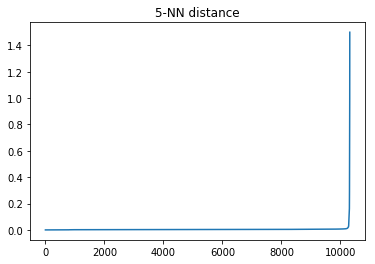

In [46]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

k = 5

neigh = NearestNeighbors(k+1)
nbrs  = neigh.fit(X)
distances, _ = nbrs.kneighbors(X)
distances    = np.sum(distances,axis=1)/k
distances.sort()


import matplotlib.pyplot as plt

plt.plot(distances)
plt.title('%d-NN distance' % k)
plt.show()

Automatically created module for IPython interactive environment
Estimated number of clusters: 6
Silhouette Coefficient: 0.812


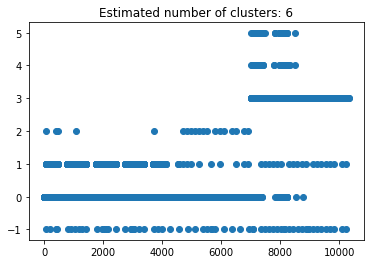

In [47]:
print(__doc__)

import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import euclidean_distances

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.02, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

x   = np.arange(len(labels))
plt.scatter(x,labels)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## TAN classifier
TAN classifier is the Tree Augmented Naive Baysian, which is created by adding a spaned tree into naive baysian network.

In [ ]:
import numpy as np
import math
from collections import defaultdict

class node:
    '''
    The class to store the information of a node in a graph
    '''
    def __init__(self,name,domain):
        self.name          = name       #a string
        self.domain        = domain     #a list for string
        self.father        = []         #a list
        self.children      = []         #a list
        self.pro_table     = {}         #init as an empty dict
                                        #for example
                                        #{(on,on):[0.1,0.9],(on,off):[0.2,0.8],(off,on):[0.3,0.7],(off,off):[0.4,0.6]}
        
    def add_father(self,fa):            #fa is a node
        self.father.append(fa)
        
    def add_child(self,ch):             #ch is a node
        self.children.append(ch)
        
    def add_pro(self,instance,table):   #instance is a string list, table is a float list
        self.pro_table[instance] = table
        
class graph:
    '''
    The class to store a graph
    The code will not check the validation of data, so please preprocess the data to ensure
    1) there are heandings: name1,name2,...
    2) no empty data
    3) all data is discretized
    4) last colum is the label
    '''
    def __init__(self):
        self.nodes         = []         #a list
        
    def get_node(self,the_node):
        '''
        functional function
        get the node by name
        input:
            variable  type    description
            ------------------------------
            the_node, string, node name
        output:
            type         description
            ------------------------------
            class node,  the found node
        '''
        names              = [i.name for i in self.nodes]
        node_index         = names.index(the_node)
        return self.nodes[node_index]
    
    def get_node_index(self,the_node):
        '''
        functional function
        get the node by name
        input:
            variable  type    description
            ------------------------------
            the_node, string, node name
        output:
            type         description
            ------------------------------
            int,         index
        '''
        names              = [i.name for i in self.nodes]
        node_index         = names.index(the_node)
        return node_index
        
    def add_node(self,name,domain):
        '''
        functional function
        add a node by name and domain
        input:
            variable  type    description
            ------------------------------
            name,     string, node name
            domain,   list,   domain of the node
        '''
        self.nodes.append(node(name,domain))
        
    def add_connection(self,from_node1,to_node2):#both from_node1 and to_node2 are strings
        '''
        functional function
        add a connection betwen to nodes
        input:
            variable     type         description
            -------------------------------------------
            from_node1,  class node,  the first node
            to_node2,    class node,  the second node
        '''
        from_node1         = self.get_node(from_node1)
        to_node2           = self.get_node(to_node2)
        
        from_node1.add_child(to_node2)
        to_node2.add_father(from_node1)
        
    def add_pro(self,the_node,instance,table):#the_node is a string
        '''
        functional function
        add a conditioanal probability P(a|b) into a node
        input:
            variable  type    description
            ------------------------------
            the_node, string, node name
            instance, list,   b part in P(a|b)
                              where each entry in it is a value in domain
            table,    list,   a part in P(a|b)
                              where each entry in it is a probability responding to a value
        '''
        the_node           = self.get_node(the_node)
        the_node.add_pro(instance,table)
        
    def get_nodes_from_data(self,headings,data):#headings = ['data1','data2',...], data = numpy 2d vector
        '''
        interface/functional function
        get the basic information about node from data and insert them into the class
        input:
            variable  type            description
            ------------------------------------------------
            headings, numpy arrary,   the names of variables
            data,     numpy 2darrary, all the data where row means different instance
                                      and col means each sensor
        '''
        for i,name in enumerate(headings):
            domain = list(set(data[:,i]))
            self.add_node(name,domain)
            
    def mutual_information(self,data1,data2):
        '''
        functional function
        get the mutual information between two cols
        input:
            variable  type            description
            ------------------------------------------------
            data1,    numpy arrary,   data of the first col
            data2,    numpy arrary,   data of the second col
        output:
            type    description
            -----------------------------
            float,  mutual information entropy with laplace smooth
        '''
        assert(len(data1)==len(data2))
        
        mi       = 0.0
        length   = len(data1)
        
        domain1 = list(set(data1))
        domain2 = list(set(data2))
        len1    = len(domain1)
        len2    = len(domain2)
        
        for x in domain1:
            for y in domain2:
                Px     = float(data1.count(x) + 1)/(length+len1)    #laplace smooth
                Py     = float(data2.count(y) + 1)/(length+len2)    #laplace smooth
                
                indexxy= [1 if (i==x)and(j==y) else 0 for i,j in zip(data1,data2)]
                Pxy    = float(sum(indexxy) + 1)/(length+len1*len2) #laplace smooth
                
                mi     = mi + Pxy*math.log(Pxy/(Px*Py))
        return mi
    
    def get_max_span_tree_prime(self,mi_dict):
        '''
        functional function
        judge if some edges compose a span tree
        input:
            variable  type    description
            -----------------------------
            edges,    dict,   all the edges
        output:
            type    description
            -----------------------------
            set,    all the edges that compose a max span tree
        '''
        #prepare structure to qurey
        Vnew  = set(max(mi_dict.items(),key=lambda d: d[1])[0][0])
        V     = set()
        Enew  = set()
        edges  = defaultdict(list)
        for i in mi_dict:
            edges[i[0]].append(i[1])
            edges[i[1]].append(i[0])
            V.add(i[0])
            V.add(i[1])
        while Vnew != V:
            new_edges = {}
            for u in Vnew:
                v = [i for i in edges[u] if i not in Vnew]
                for vi in v:
                    edge = (u,vi) if (u,vi) in mi_dict else (vi,u)
                    new_edges[edge] = mi_dict[edge]
            new_edges = sorted(new_edges.items(),key=lambda d:d[1],reverse = True)
            best_edge = new_edges[0]
            Enew.add(best_edge[0])
            Vnew.add(best_edge[0][0])
            Vnew.add(best_edge[0][1])
        return Enew
        
        
    def get_basic_tan_structure(self,headings,data):#headings = ['data1','data2',...], data = numpy 2d vector
        '''
        interface function
        get the basic structure of TAN and connect the nodes in the class.
        we assumpe that the last col is the label colum and is ignored when handle features
        input:
            variable  type            description
            --------------------------------------------------
            headings, numpy arrary,   names of variables/nodes
            data,     numpy arrary,   all the monitor data
        '''
        #computing mutual information entropy between features
        mi_dict = {}
        for i in range(len(headings)-1):
            for j in range(i+1,len(headings)-1):
                data1   = data[:,i]
                data2   = data[:,j]
                mi      = self.mutual_information(data1,data2)
                mi_dict[(headings[1],headings[2])] = mi
        
        #set maximal span tree, mst
        mst             = self.get_max_span_tree_prime(mi_dict)
        Visited         = set()
        edges           = defaultdict(list)
        for i in mst:
            edges[i[0]].append(i[1])
            edges[i[1]].append(i[0])
        initial_node    = self.node[0].name
        start           = [initial_node]
        Visited.add(initial_node)
        while len(start)!=0:
            new_start = []
            for i in start:
                ends = edges[i]
                for j in ends:
                    if j not in Visited:
                        Visited.add(j)
                        new_start.append(j)
                        self.add_connection(i,j)
            start = new_start
        
        #set the connection between label and features
        for i in range(len(self.nodes)-1):
            self.add_connection(self.node[-1],self.node[i])
            
    def get_cpt(self,headings,data,node_name):
        '''
        interface/functional function
        calculate the condition probability table based on the basic structure
        input:
            variable  type            description
            --------------------------------------------------
            headings, numpy arrary,   names of variables/nodes
            data,     numpy arrary,   all the monitor data
            node_name,string,         the node name
        '''
        the_index     = self.get_node_index(node_name)
        the_node      = self.nodes[the_index]
        father_nodes  = the_node.father
        
        domain_x = the_node.domain
        data_x   = data[:,the_index]
        len_x    = len(domain_x)
        
        length   = len(data)
        
        if len(father_nodes) == 0:
            return
        else if len(father_nodes)==1:#y-->x
            domain_y = father_nodes[0].domain
            data_y   = data[:,self.get_node_index(father_nodes[0].name)]
            len_y    = len(domain_y)
            
            for y in domain_y:
                table    = []
                Py     = float(data_y.count(y) + 1)/(length+len_y)    #laplace smooth
                for x in domain_x:
                    indexxy= [1 if (i==x)and(j==y) else 0 for i,j in zip(data_x,data_y)]
                    Pxy    = float(sum(indexxy) + 1)/(length+len_x*len_y) #laplace smooth
                    table.append(float(Pxy)/Py)
                self.add_pro(node_name,(y),table)
                    
        else if len(father_nodes)==2:
            domain_y = father_nodes[0].domain
            data_y   = data[:,self.get_node_index(father_nodes[0].name)]
            len_y    = len(domain_y)
            domain_z = father_nodes[1].domain
            data_z   = data[:,self.get_node_index(father_nodes[1].name)]
            len_z    = len(domain_z)
            
            for y in domain_y:
                for z in domian_z:
                    table = []
                    indexyz= [1 if (i==y)and(j==z) else 0 for i,j in zip(data_y,data_z)]
                    Pyz    = float(sum(indexyz) + 1)/(length+len_y*len_z) #laplace smooth
                    for x in domain_x:
                        indexxyz= [1 if (i==y)and(j==z)and(k==x) else 0 for i,j,k in zip(data_y,data_z,data_x)]
                        Pxyz    = float(sum(indexxyz) + 1)/(length+len_y*len_z*len_x) #laplace smooth
                        table.append(float(Pxyz)/Pyz)
                    self.add_pro(node_name,(y,z),table)
        else:
            assert(len(father_nodes)<=2

        
    def train(self,headings,data):
        '''
        interface function
        calculate the condition probability table based on the basic structure
        input:
            variable  type            description
            --------------------------------------------------
            headings, numpy arrary,   names of variables/nodes
            data,     numpy arrary,   all the monitor data
        '''
        for i in self.nodes:
            self.get_cpt(headings,data,i.name)
        
        